<a href="https://colab.research.google.com/github/gopi231091/YOLO/blob/master/Yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Getting Necessary Files**

In [1]:
!git clone https://github.com/gopi231091/YOLO

Cloning into 'YOLO'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 36 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (36/36), done.


In [2]:
!wget https://www.dropbox.com/s/7quj1bsfyhqrhu4/yolov3.h5

--2019-05-24 12:09:25--  https://www.dropbox.com/s/7quj1bsfyhqrhu4/yolov3.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1, 2620:100:6030:1::a27d:5001
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7quj1bsfyhqrhu4/yolov3.h5 [following]
--2019-05-24 12:09:25--  https://www.dropbox.com/s/raw/7quj1bsfyhqrhu4/yolov3.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc83d6b3810b4ef373bce644ab9d.dl.dropboxusercontent.com/cd/0/inline/Ahfq6qW4FeVy73VFClG8diYlt6g5dHxNtE4gAMqcD5QLhshdvul3TpcDdqXvl8tdLenu3zX-auwFvpJ1WEoBDDJ4SBcYpg9qBTXYehVTEtkHsw/file# [following]
--2019-05-24 12:09:26--  https://uc83d6b3810b4ef373bce644ab9d.dl.dropboxusercontent.com/cd/0/inline/Ahfq6qW4FeVy73VFClG8diYlt6g5dHxNtE4gAMqcD5QLhshdvul3TpcDdqXvl8tdLenu3zX-auwFvpJ1WEoBDDJ4SBcYpg9qBTXYehVTEtkHsw/file
Resolving uc83d6b3810b4ef

In [0]:
!mv yolov3.h5 /content/YOLO/model_data


In [0]:
import os
os.chdir('/content/YOLO')

# **YOLO**

## **Import** 

In [5]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from models.model import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

Using TensorFlow backend.


## **Filtering Boxes (threshold and NMS)**

### **Filtering with a threshold on class scores**

In [0]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Step 1: Compute box scores
    box_scores = box_confidence * box_class_probs
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    filtering_mask = box_class_scores >= threshold
    
    # Step 4: Apply the mask to scores, boxes and classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

### **Non-max Suppression**

#### **IoU**

In [0]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = np.amax([box1[0], box2[0]])
    yi1 = np.amax([box1[1], box2[1]])
    xi2 = np.amin([box1[2], box2[2]])
    yi2 = np.amin([box1[3], box2[3]])
    inter_area = np.amax([yi2-yi1, 0]) * np.amax([xi2-xi1, 0])

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[3]-box1[1]) * (box1[2]-box1[0])
    box2_area = (box2[3]-box2[1]) * (box2[2]-box2[0])
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area / union_area
    
    return iou

#### **NMS**

In [0]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

###**Wrapping Filter**

In [0]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
   
    # Retrieve outputs of the YOLO model
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    
    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
       
    return scores, boxes, classes

## **Main YOLO Class**

In [0]:
"""
Class definition of YOLOv3 detection model on image and video
"""

import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from models.model import yolo_body, tiny_yolo_body, yolo_head, yolo_eval
from models.utils import letterbox_image
import os
from keras.utils import multi_gpu_model

class YOLO(object):
    _defaults = {
        "model_path": 'model_data/yolov3.h5',
        "anchors_path": 'model_data/yolo_anchors.txt',
        "classes_path": 'model_data/coco_classes.txt',
        "score" : 0.3,
        "iou" : 0.45,
        "model_image_size" : (416, 416),
        "gpu_num" : 1,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        """
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors)) """
        self.colors = generate_colors(self.class_names)
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        '''# Convert output of model to usable bounding box tensors (returns box_xy, box_wh, box_confidence, box_class_probs)
        self.yolo_outputs = yolo_head(self.yolo_model.output[1], self.anchors, len(self.class_names), self.input_image_shape)
        # Filtering boxes with yolo_eval 
        scores, boxes, classes = yolo_eval(self.yolo_outputs, image_shape = self.input_image_shape, max_boxes=20, score_threshold=self.score, iou_threshold=self.iou)
        '''
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        
        return boxes, scores, classes

    def detect_image(self, image):
        start = timer()

        # Pre-Process Image
        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        # Draw Boxes
        font = ImageFont.truetype(font='font/FiraMono-Medium.otf', size = 12)
                    #size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        end = timer()
        print(end - start)
        return image
      
    def close_session(self):
        self.sess.close()

def detect_video(yolo, video_path, output_path=""):
    import cv2
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    #video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_FourCC    = cv2.VideoWriter_fourcc('M','J','P','G')
    #video_FourCC    = cv2.VideoWriter_fourcc(*'DIVX')
    video_fps       = vid.get(cv2.CAP_PROP_FPS)
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                        int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)))
    isOutput = True if output_path != "" else False
    print(isOutput)
    if isOutput:
        print("!!! TYPE:", type(output_path), type(video_FourCC), type(video_fps), type(video_size))
        out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
    accum_time = 0
    curr_fps = 0
    fps = "FPS: ??"
    prev_time = timer()
    while(vid.isOpened()):
        return_value, frame = vid.read()
        if return_value:
          frame = cv2.transpose(frame)
          frame = cv2.flip(frame, 1)
          image = Image.fromarray(frame)
          image = yolo.detect_image(image)
          result = np.asarray(image)
          curr_time = timer()
          exec_time = curr_time - prev_time
          prev_time = curr_time
          accum_time = accum_time + exec_time
          curr_fps = curr_fps + 1
          if accum_time > 1:
              accum_time = accum_time - 1
              fps = "FPS: " + str(curr_fps)
              curr_fps = 0
          cv2.putText(result, text=fps, org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                      fontScale=0.50, color=(255, 0, 0), thickness=2)
          '''cv2.namedWindow("result", cv2.WINDOW_NORMAL)
          cv2.imshow("result", result)'''

          '''plt.axis('off')
          plt.figtext(0.8, 0.8, fps)
          plt.imshow(result)
          plt.show()'''
          if isOutput:
              out.write(result)
        else:
          break
        if cv2.waitKey(1) & 0xFF == ord('q'):
          break
    out.release()  
    #yolo.close_session()


In [15]:
yolo = YOLO()

model_data/yolov3.h5 model, anchors, and classes loaded.


In [16]:
detect_video(yolo, '/content/00cee0e0-5e25daa7.mov', '/content/bddout_00cee0e0-5e25daa7.avi')

True
!!! TYPE: <class 'str'> <class 'int'> <class 'float'> <class 'tuple'>
(416, 416, 3)
Found 2 boxes for img
car 0.40 (986, 617) (1209, 717)
car 0.74 (661, 586) (744, 643)
3.8025791460000846
(416, 416, 3)
Found 5 boxes for img
traffic light 0.34 (371, 406) (404, 440)
car 0.34 (388, 602) (423, 626)
car 0.39 (797, 579) (1020, 691)
car 0.59 (553, 586) (650, 635)
car 0.73 (662, 584) (749, 639)
0.09187080200001674
(416, 416, 3)
Found 4 boxes for img
car 0.32 (263, 591) (351, 643)
car 0.32 (304, 599) (354, 635)
car 0.34 (669, 583) (749, 636)
car 0.49 (390, 600) (421, 623)
0.08503594299997985
(416, 416, 3)
Found 3 boxes for img
car 0.31 (669, 581) (750, 638)
car 0.40 (388, 599) (420, 622)
car 0.43 (138, 607) (226, 667)
0.07969224399994346
(416, 416, 3)
Found 4 boxes for img
car 0.32 (388, 597) (421, 623)
car 0.41 (287, 599) (340, 636)
car 0.52 (675, 579) (761, 642)
car 0.62 (135, 609) (224, 667)
0.07659412600003179
(416, 416, 3)
Found 4 boxes for img
car 0.32 (285, 601) (340, 638)
car 0.34 

In [0]:
def detect_img(yolo, imgPath):
  try:
    image = Image.open(imgPath)
  except:
    print('Open Error! Try again!')
  else:
    r_image = yolo.detect_image(image)
    #r_image.show()
    plt.axis('off')
    plt.imshow(r_image)
    plt.show()
  yolo.close_session()

(416, 416, 3)
Found 9 boxes for img
motorbike 1.00 (240, 186) (469, 349)
person 0.55 (583, 47) (619, 168)
person 0.83 (558, 57) (595, 185)
person 0.86 (506, 54) (543, 164)
person 0.87 (487, 54) (523, 164)
person 0.93 (361, 107) (387, 158)
person 0.95 (415, 123) (481, 172)
person 0.99 (245, 35) (292, 133)
person 1.00 (258, 89) (445, 268)
1.3086700430001201


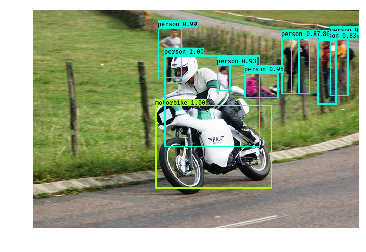

In [0]:
detect_img(yolo, '/content/000000007816.jpg')